In [25]:
from project import MartiniProject
import signac
import numpy as np
import pandas as pd
import os
import networkx as nx
from os.path import join
from alchemlyb.parsing.gmx import extract_u_nk
from alchemlyb.estimators import MBAR
from alchemlyb.visualisation import plot_dF_state
import matplotlib.pyplot as plt

In [26]:
project = MartiniProject().init_project()

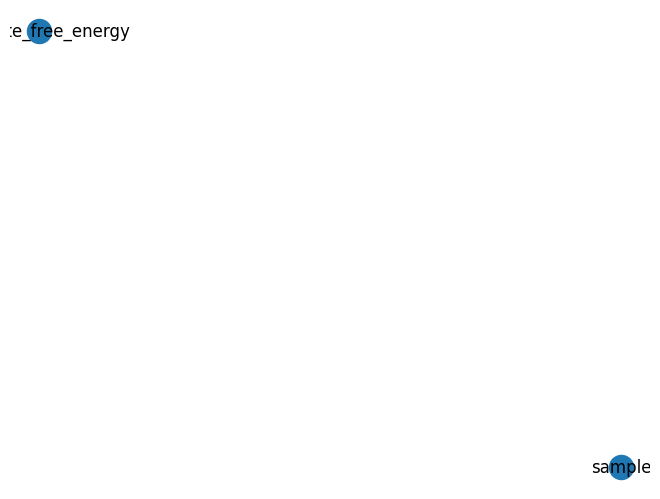

In [27]:
ops = project.operations.keys()
adj = np.asarray(project.detect_operation_graph())

plt.figure()
g = nx.DiGraph(adj)
pos = nx.spring_layout(g)
nx.draw(g, pos)
nx.draw_networkx_labels(
    g, pos,
    labels={key: name for (key, name) in
            zip(range(len(ops)), [o for o in ops])})

plt.show()

In [18]:
jobs = MartiniProject().find_jobs()
jobs

,sp.lambda_state
01a63b22db35a5f7008102d12b70f4da,0
22d4866ce5bd19769f025982fa117bdd,6
3200e6249c43d458249916a5fe8a3614,2
3cd5b537b11def653cc59df3fb37c229,10
591acce991221b1138cfe5343cfb1a44,8
64d9244812a356e19738e0396c23b650,5
763ecfc477b8ee1f032e78bef797fdf6,3
77e0d9ffe33c41244aadc65f75139d4e,4
83997b1e23c22aa720eecabfc3265ec5,7
85928b5c22176a2ebb352570568cf244,9


In [16]:
for job in jobs:
    print(job)

591acce991221b1138cfe5343cfb1a44
83997b1e23c22aa720eecabfc3265ec5
01a63b22db35a5f7008102d12b70f4da
85928b5c22176a2ebb352570568cf244
3cd5b537b11def653cc59df3fb37c229
f42be03154f5679bd6010a5022ad617f
22d4866ce5bd19769f025982fa117bdd
64d9244812a356e19738e0396c23b650
77e0d9ffe33c41244aadc65f75139d4e
3200e6249c43d458249916a5fe8a3614
763ecfc477b8ee1f032e78bef797fdf6


In [23]:
xvg_files = [
    join(job.path, f) for job in jobs
    for f in os.listdir(job.path)
    if ".xvg" in f
]
TEMPERATURE = 298
u_nk_list = [extract_u_nk(f, T=TEMPERATURE) for f in xvg_files]
u_nk_combined = pd.concat(u_nk_list)

In [25]:
mbar = MBAR().fit(u_nk_combined)


******* JAX 64-bit mode is now on! *******
*     JAX is now set to 64-bit mode!     *
*   This MAY cause problems with other   *
*      uses of JAX in the same code.     *
******************************************



In [45]:
df = mbar.delta_f_
df

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0.0,0.000000,0.779192,1.502135,2.154666,2.717363,3.155350,3.393083,3.161848,1.888100,0.621223,0.022224
0.1,-0.779192,0.000000,0.722944,1.375474,1.938172,2.376158,2.613891,2.382656,1.108908,-0.157968,-0.756968
0.2,-1.502135,-0.722944,0.000000,0.652530,1.215228,1.653215,1.890948,1.659712,0.385964,-0.880912,-1.479912
0.3,-2.154666,-1.375474,-0.652530,0.000000,0.562698,1.000685,1.238418,1.007182,-0.266566,-1.533442,-2.132442
0.4,-2.717363,-1.938172,-1.215228,-0.562698,0.000000,0.437987,0.675720,0.444484,-0.829263,-2.096140,-2.695140
0.5,-3.155350,-2.376158,-1.653215,-1.000685,-0.437987,0.000000,0.237733,0.006498,-1.267250,-2.534127,-3.133126
0.6,-3.393083,-2.613891,-1.890948,-1.238418,-0.675720,-0.237733,0.000000,-0.231235,-1.504983,-2.771860,-3.370859
0.7,-3.161848,-2.382656,-1.659712,-1.007182,-0.444484,-0.006498,0.231235,0.000000,-1.273748,-2.540624,-3.139624
0.8,-1.888100,-1.108908,-0.385964,0.266566,0.829263,1.267250,1.504983,1.273748,0.000000,-1.266877,-1.865876
0.9,-0.621223,0.157968,0.880912,1.533442,2.096140,2.534127,2.771860,2.540624,1.266877,0.000000,-0.598999


In [46]:
df.to_csv?

In [29]:
mbar.d_delta_f_

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0.0,0.000000,0.002713,0.005333,0.007910,0.010498,0.013241,0.016504,0.021531,0.028997,0.031992,0.033280
0.1,0.002713,0.000000,0.002776,0.005637,0.008578,0.011675,0.015260,0.020593,0.028308,0.031369,0.032681
0.2,0.005333,0.002776,0.000000,0.003042,0.006315,0.009825,0.013823,0.019548,0.027558,0.030693,0.032034
0.3,0.007910,0.005637,0.003042,0.000000,0.003504,0.007453,0.011993,0.018266,0.026664,0.029894,0.031269
0.4,0.010498,0.008578,0.006315,0.003504,0.000000,0.004287,0.009476,0.016549,0.025516,0.028876,0.030297
0.5,0.013241,0.011675,0.009825,0.007453,0.004287,0.000000,0.005755,0.013970,0.023869,0.027437,0.028929
0.6,0.016504,0.015260,0.013823,0.011993,0.009476,0.005755,0.000000,0.009533,0.021057,0.025035,0.026668
0.7,0.021531,0.020593,0.019548,0.018266,0.016549,0.013970,0.009533,0.000000,0.013513,0.018451,0.020580
0.8,0.028997,0.028308,0.027558,0.026664,0.025516,0.023869,0.021057,0.013513,0.000000,0.006329,0.009872
0.9,0.031992,0.031369,0.030693,0.029894,0.028876,0.027437,0.025035,0.018451,0.006329,0.000000,0.004141


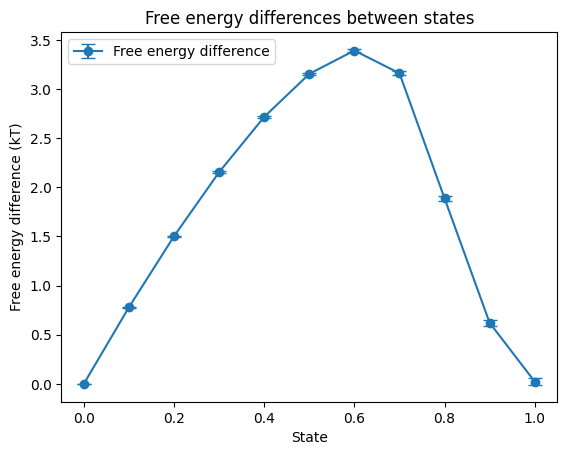

In [38]:
# Extracting free energy differences between the first and last state
delta_f_values = mbar.delta_f_.iloc[0, :].values
d_delta_f_values = mbar.d_delta_f_.iloc[0, :].values

# Plotting free energy differences
states = mbar.delta_f_.columns
plt.errorbar(states, delta_f_values, yerr=d_delta_f_values,
             marker='o', linestyle='-',
             capsize=5, label="Free energy difference")

plt.xlabel('State')
plt.ylabel('Free energy difference (kT)')
plt.title('Free energy differences between states')
plt.legend()

# Display the plot
plt.show()

In [39]:
delta_f_values

array([0.        , 0.77919173, 1.50213548, 2.15466556, 2.7173634 ,
       3.15535012, 3.39308314, 3.16184781, 1.88809994, 0.62122333,
       0.02222386])